Training complete!

					Q-table 
--------------------------------------------------
	 Up 		 Right 		 Down 	 Left
--------------------------------------------------
    0.8800     0.9200     0.8400     0.8800 

    0.9200     0.9600     0.9200     0.8800 

    0.9600     1.0000     0.9200     0.9200 

    0.0000     0.0000     0.0000     0.0000 

    0.8800     0.8400     0.8000     0.8400 

    0.9788     0.8012     0.4669     0.7827 

    0.9600    -0.8543     0.7200     0.5916 

    0.0000     0.0000     0.0000     0.0000 

    0.8400     0.7600     0.8000     0.8000 

    0.6961     0.7011     0.7461     0.8000 

    0.5947     0.4483     0.6294     0.7600 

    0.0958     0.2187     0.1945     0.6318 

--------------------------------------------------

The optimal path is: 
[(2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3)]



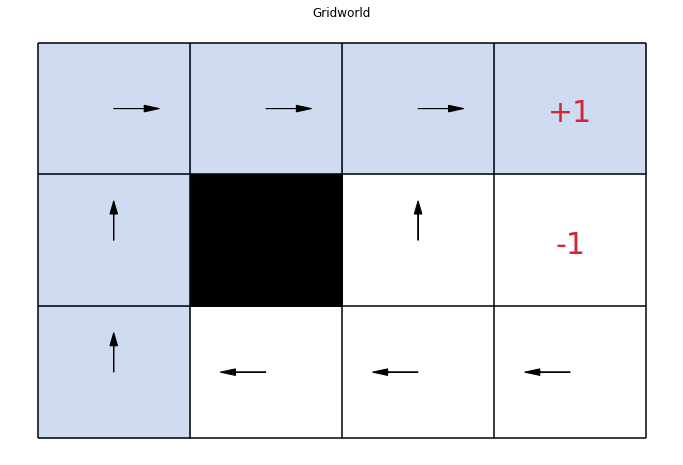

In [10]:
"""
     *** Reinforcement Learning in Robotics ***
     ------------------------------------------
    Train an agent on a gridworld with Q-Learning.

Date:   Fall 2021
Author: elena_ecn 
"""

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class Env:
    def __init__(self, rows, columns):      
        self.rows = rows                                    # Number of rows of gridworld
        self.columns = columns                              # Number of columns of gridworld
        self.num_states = rows*columns                      # Number of states
        self.actions = self.define_actions()                # Define the actions the agent can take
        self.num_actions = len(self.actions)                # Number of actions the agent can take
        self.rewards = self.define_rewards()                # Define the reward for each state
        self.obstacles = self.define_obstacles()            # Define the obstacles of the environment
        self.states = [(i,j) for i in range(rows) for j in range(columns)]  # State coordinates   
        self.directions = ['front', 'to_left', 'to_right']  # Non deterministic dynamics
        self.distribution = [.8, .1, .1]                    # Probability distribution of dynamics            
    
    def define_actions(self):
        """Define the possible actions that the agent can take."""
        actions = ['up', 'right', 'down', 'left']  # 0 = up, 1 = right, 2 = down, 3 = left       
        return actions   
    
    def define_rewards(self):
        """Define the reward for each state."""
        rewards = -0.04*np.ones([rows, columns])
        rewards[0, 3] = 1.0
        rewards[1, 3] = -1.0      
        return rewards
    
    def define_obstacles(self):
        """Define the obstacles of the environment and set their rewards to None."""
        obstacles = [(1,1)]           # Locations of obstacles
        for obs in obstacles:
            self.rewards[obs] = None  # Set reward of obstacle locations to None
        return obstacles

    def is_terminal_state(self, state):
        """Determines whether the state is terminal. 
        
        Inputs:
          - state(tuple): A state of the environment
        Returns:
          - (bool):       Whether the state is terminal or not
        """    

        if self.rewards[state] == -1.0 or self.rewards[state] == 1.0:
            return True 
        else:
            return False
    
    def get_next_state(self, state, action):
        """Get the next state based on the current state and the chosen action.
        
        The dynamics are non-deterministic and the agent transitions to the desired 
        state with a high probability but might slip to the left or to the right.
        Inputs:
          - state(tuple): The current state of the agent
          - action(int):  The chosen action to take
        Returns:
          - (tuple):      The next state of the agent
        """
        action_word = self.actions[action]  # Get the action in text form

        # Adjust action if agent 'slips'
        non_determ_direction = random.choices(self.directions, self.distribution)
        if non_determ_direction == 'to_left':
            if action_word == 'up':
                action_word = 'left'
            elif action_word == 'right':
                action_word = 'up'
            elif action_word == 'down':
                action_word = 'right'
            elif action_word == 'left':
                action_word = 'down'
        elif non_determ_direction == 'to_right':
            if action_word == 'up':
                action_word = 'right'
            elif action_word == 'right':
                action_word = 'down'
            elif action_word == 'down':
                action_word = 'left'
            elif action_word == 'left':
                action_word = 'up'

        # Make permissible movement
        row, column = state
        if action_word == 'up' and row > 0 and ((row-1, column) not in self.obstacles):        
            row -= 1     # If agent is not at the upper wall or at obstacle, move up.
        elif action_word == 'right' and column < self.columns - 1 and ((row, column+1) not in self.obstacles):
            column += 1  # If agent is not at the right wall or at obstacle, move right.
        elif action_word == 'down' and row < self.rows - 1 and ((row+1, column) not in self.obstacles):
            row += 1     # If agent is not at the bottom wall or at obstacle, move down.
        elif action_word == 'left' and column > 0 and ((row, column-1) not in self.obstacles):
            column -= 1  # If agent is not at the left wall or at obstacle, move left.

        return (row, column)  # Next state 


class Agent:
    def __init__(self, env, start_state, a, epsilon): 
        self.env = env                        # The environment class
        self.num_actions = env.num_actions    # Number of actions the agent can take
        self.start_state = start_state        # The state that the agent begins in
        self.epsilon = epsilon                # Exploration probability
        self.q_table = self.define_q_table()  # The Q-table
        self.a = a                            # Learning rate

    def define_q_table(self):
        """Initializes the Q-table arbitrarily except Q(terminal,.)=0."""
        q_table = np.random.uniform(low=0.01, high=1.0, size=(self.env.num_states, self.num_actions))
        
        for state in self.env.states:
            if self.env.is_terminal_state(state):
                state_idx = self.env.states.index(state)                
                q_table[state_idx, :] = 0
        return q_table

    def choose_action(self, state):
        """Choose next action to take from current state with epsilon-greedy policy.

        Explore the environment with probability epsilon and
        Exploit knowledge and take greedy action with probability (1-epsilon).
        Inputs:
          - state(tuple): The current state of the agent
        Returns:
          - action(int):  The next action to take
        """

        if np.random.random() < self.epsilon:         
            action = np.random.randint(self.num_actions)  # Explore environment      
        else: 
            state_idx = self.env.states.index(state)      # State index
            action = np.argmax(self.q_table[state_idx])   # Exploit learned values
        return action    
    
    def choose_action_trained(self, state):
        """Choose the best next action to take from the current state.

        Inputs:
          - state(tuple): The current state of the agent
        Returns:
          - (int):        The next action to take
        """
        state_idx = self.env.states.index(state)          # State index
        return np.argmax(self.q_table[state_idx])         # Best action

    def get_path(self, init_state):
        """Get the path from the initial state to a terminal state.
        
        Inputs:
          - init_state(tuple): The initial state that the agent begins in
        Returns:
          - path(list):        The sequence of states the agent takes
        """

        state = init_state
        path = [state]
        while not self.env.is_terminal_state(state):
            action = self.choose_action_trained(state)            
            state = self.env.get_next_state(state, action)
            path.append(state)
        return path
    
    def train(self, init_state, episodes):
        """Trains the agent via Q-Learning.
        
        Updates the Q-table with the optimal policy.
        Inputs:
          - init_state(tuple): The initial state that the agent begins in
          - episodes(int):     Number of episodes to train for
        """

        gamma = 1.0      # Discount factor for future rewards

        for episode in range(episodes):
            state = init_state  # Initialize/reset state

            while not self.env.is_terminal_state(state):
                
                # Choose action to take
                action = self.choose_action(state)  

                # Take chosen action and transition to the next state 
                next_state = self.env.get_next_state(state, action)
                
                # Receive the reward 
                reward = self.env.rewards[next_state]                

                # Update Q-value 
                state_idx = self.env.states.index(state)            # State index
                next_state_idx = self.env.states.index(next_state)  # Next state index
                q_value = self.q_table[state_idx, action]
                self.q_table[state_idx, action] = q_value + self.a*(reward + gamma*np.max(self.q_table[next_state_idx]) - q_value)
                
                # Update state
                state = next_state
            
        print('Training complete!\n')


def plot_path(path, q_table, env):
    """Plots the optimal path in the gridworld environment.
    
    Inputs:
      - path(list):          The optimal path
      - q_table(np.ndarray): The Q-table
      - env(class.Env):      The environment
    """
    rows = env.rows
    columns = env.columns
            
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_title('Gridworld')
    plt.axis('off')

    # Grid
    for row in range(rows+1):
        ax.hlines(y=row, xmin=0, xmax=columns, linewidth=1.5, color='k')    
    for column in range(columns+1):
        ax.vlines(x=column, ymin=0, ymax=rows, linewidth=1.5, color='k')
    
    # Obstacles
    for obs in env.obstacles:
        row, col = obs
        ax.add_patch(Rectangle((col, rows-1-row), 1, 1, color='k'))

    # Annotate terminal states (hard-coded)
    ax.annotate('+1', xy=(3.35, 2.4),color='#d42436', size='30')
    ax.annotate('-1', xy=(3.4, 1.4),color='#d42436', size='30')

    # Show path
    for state in path:
        row, col = state
        ax.add_patch(Rectangle((col, rows-1-row), 1, 1, color="#104fb5", alpha=0.2))
    
    # Optimal Policy (best action arrows)
    optimal_actions = [np.argmax(row) for row in q_table]
    for i in range(rows):
        for j in range(columns):   

            state_idx = env.states.index((i, j))   # State index
            if optimal_actions[state_idx] == 0:    # up
                dx, dy = 0, 0.2
            elif optimal_actions[state_idx] == 1:  # right
                dx, dy = 0.2, 0
            elif optimal_actions[state_idx] == 2:  # down
                dx, dy = 0, -0.2
            else:                                  # left
                dx, dy = -0.2, 0
            
            if env.is_terminal_state((i, j)):
                break  # If terminal state, don't draw arrow
            plt.arrow(j+0.5, rows-1-i+0.5, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')
   
    plt.show()


def show_q_table(q_table):
    """Prints the Q-table in a more readable format."""

    print('\t'*5 + 'Q-table \n' + '-'*50)
    print('\t Up \t\t Right \t\t Down \t Left\n' + '-'*50 )    
    rows, columns = q_table.shape
    for i in range(rows):
        for j in range(columns):
            print('{:10.4f}'.format(q_table[i, j]), end=' ')
        print('\n')
    print('-'*50 + '\n')


if __name__ == "__main__":

    np.random.seed(0)    # To make runs repeatable

    # Parameters
    # -------------------------------------------------------------------------
    rows = 3             # Number of rows of the gridworld 
    columns = 4          # Number of columns of the gridworld
    start_state = (2,0)  # State the agent begins in
    eps = 0.1            # Exploration probability
    N = 20000            # Number of episodes to train for
    a = 0.1              # Learning rate

    # Train the agent
    # -------------------------------------------------------------------------
    env = Env(rows, columns)                                   # Define environment
    agent = Agent(env, start_state, a, eps)                    # Define agent
    agent.train(start_state, N)                                # Train the AI agent
            
    # Display results
    # -------------------------------------------------------------------------
    show_q_table(agent.q_table)                                # Display final Q-table
    optimal_path = agent.get_path(start_state)                 # Find optimal path
    print('The optimal path is: \n{}\n'.format(optimal_path))  # Display optimal path       

    # Plot the optimal path in the gridworld environment
    plot_path(optimal_path, agent.q_table, env)   
